### Introduction

This notebook demonstrates a small Python library for loading, processing, and visualizing data from the Global Historical Climatology Network (GHCN). The data (about 30GB, total) must be downloaded to the local machine along with a couple of text files containing metadata. See this project's GitHub README.md for downloading instructions.

The library consists of three Python modules: *ghcn.py*, *mapping.py*, and *analysis.py*, which should be located in this notebook's folder.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Local modules...
import ghcn
import mapping as map_
import analysis as anly

### Loading the data 'description'

Create a Ghcn object, giving it the paths to the data and doc files. As it is constructed it with will read the *ghcnd-stations.txt* and *ghcnd-inventory.txt* files from the docs folder, build a list of available climate data 'stations', and construct a histogram of their years of operation.

This notebook only uses the maximum-temperature (TMAX) data element but most stations also capture data for minimum-temperature (TMIN), precipitation (PRCP), snowfall (SNOW) and snow-depth (SNWD).

In [2]:
# The data element we'll be looking at in this Notebook is 'TMAX'.
this_elem = 'TMAX'

# The Ghcn constructor takes a tuple of element names but
# only uses the first one at this time.
ghcn_obj = ghcn.Ghcn('/media/data/GHCN', 'ghcnd_all', 'docs', (this_elem, ))

per_year = ghcn_obj.stations_per_year()

reading '/media/data/GHCN/docs/ghcnd-stations.txt'...
mkstation n_lines = 113948
reading '/media/data/GHCN/docs/ghcnd-inventory.txt'...
mkhistogram n_lines = 630727


### *Active Stations by Year* histogram

Create a function for plotting the number of stations that were capturing TMAX data from 1893 through 2019.

In [3]:
def plot_histogram(per_year, elems):
    """Plot the 'active stations by year' histogram.

    """
    # Make years and labels lists for ALL years...
    years = []
    labels = []
    for i in range(per_year['firstYear'], per_year['lastYear'] + 1):
        years.append(i)
        labels.append(str(i) if (i % 10) == 0 else '')

    # ... But let's skip plotting the first 130 years
    # 1893 is the first year when there were more than 1000 stations.
    year_bgn_plot = 130

    plt.figure(figsize=(15, 3))
    plt.title('Number of Active Stations per year recording ' +
              ', '.join(elems))
    plt.bar(years[year_bgn_plot:],
            per_year['histo'][year_bgn_plot:],
            width=0.6,
            snap=False,
            alpha=0.65)
    plt.xticks(years[year_bgn_plot:], labels[year_bgn_plot:], rotation=90)

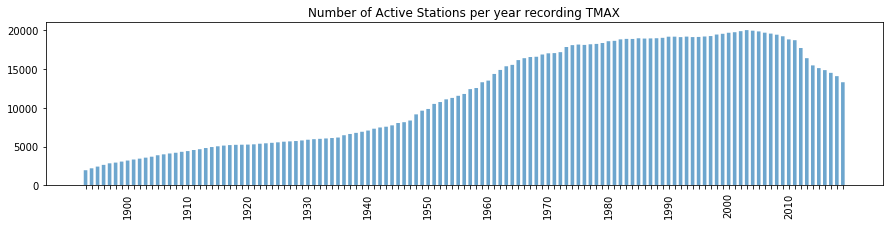

In [4]:
plot_histogram(per_year, (this_elem, ))

### Prune the list of stations...

Get the list of stations that have been active for at least 25 years *and* include the year 2015.

In [5]:
stations = ghcn_obj.get_stations(this_elem, min_yrs=25, must_include=2015)
# 'stations' is a list of metadata dictionaries.
print("n stations = " + str(len(stations)))

n stations = 10896


### ... And show the reduced set of stations on a world map

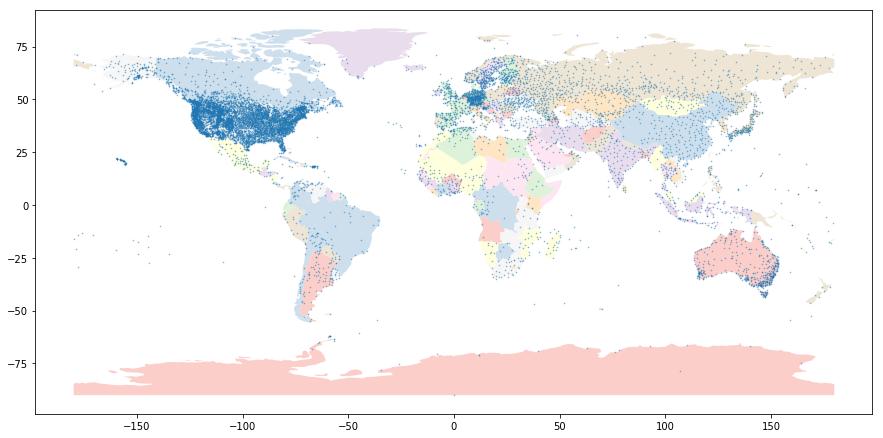

In [6]:
world_map = map_.Mapping()
for station in stations:
    world_map.add_location(station)
world_map.show()

### Create functions to support data plotting...

Create a polynomial regression function that will curve-fit one year of data. And create a helper function that talks to the analysis.plot_years() function; see analysis.py for more info.

In [7]:
def polynomial_regression(x, y, deg):
    """Fit the {x, y} data with a curve.

    """
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    x_poly = poly_features.fit_transform(x)

    lin_reg = LinearRegression()
    lin_reg.fit(x_poly, y)

    length = len(x)
    x_new = np.linspace(0, length - 1, length).reshape(length, 1)
    x_new_poly = poly_features.transform(x_new)
    y_new = lin_reg.predict(x_new_poly)
    return {'x': x_new, 'y': y_new}


def plot_station(elem, obj):
    """Plot the first and last active years for a station.

    """
    ghcn_data = obj['ghcn_data']
    df = obj['df']
    id_ = ghcn_data['id']
    years = [a for a in ghcn_data['data'][0][elem]]
    if not years:
        return

    years = ghcn.only_1st_and_lst(years)
    anly.plot_years(df, id_, polynomial_regression, years)

### ... And plot the first and last years of max-temperature data for a few stations

In [8]:
# Sort to easily display the longest-active stations first.
stations.sort(key=lambda e: e['elems'][this_elem]['yearBgn'] - e['elems'][this_elem]['yearEnd'])

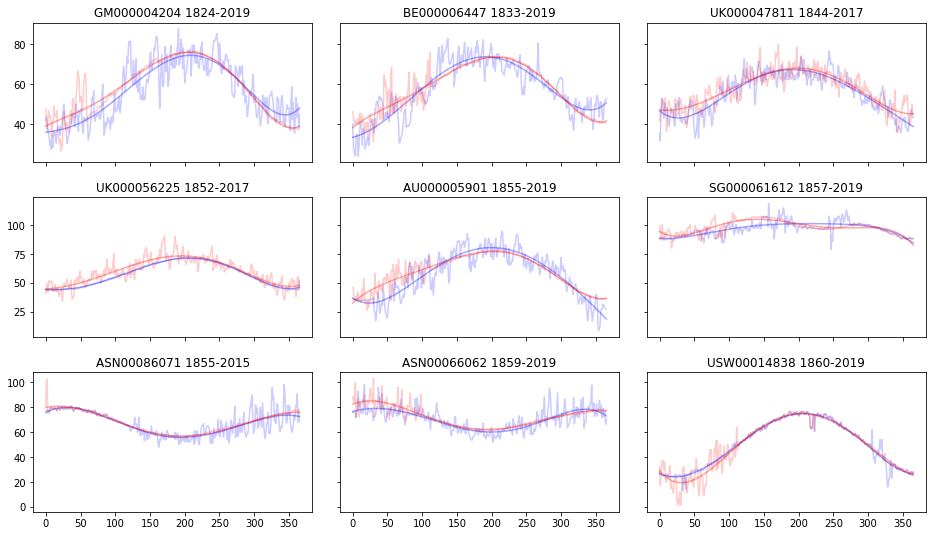

In [9]:
f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(16, 9))
f.subplots_adjust(hspace=0.25, wspace=0.1)

# Set up a 3x3 plot...
anly.PLOT_LAYOUT = []
anly.PLOT_LAYOUT_INDEX = 0
for y in range(3):
    for x in range(3):
        anly.PLOT_LAYOUT.append(axarr[y, x])

# ... And draw 9 graphs.
for item in stations[0:9]:
    obj = ghcn.to_dataframe(ghcn_obj, item['id'])
    try:
        obj['ghcn_data']
    except KeyError:
        continue

    plot_station(this_elem, obj)

### Up Next...

Some actual machine learning to predict 'future' max temperatures. Stay tuned...